In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import math
import matplotlib.pyplot as plt
from torchsummary import summary

### Download dataset

In [ ]:
# Download the train dataset
!wget https://github.com/Wayan123/my-computer-vision-labs/raw/main/train.zip

# Download the validation dataset
!wget https://github.com/Wayan123/my-computer-vision-labs/raw/main/valid.zip

In [2]:
#Import Library OS/Zipfile
import os
import zipfile

local_zip = 'train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
local_zip = 'valid.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

## Class KANLinier

In [3]:
# KANLinear definition Soure: https://github.com/Blealtan/efficient-kan/blob/f39e5146af34299ad3a581d2106eb667ba0fa6fa/src/efficient_kan/kan.py#L6
class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


## Main Code

In [4]:
# CNN model for CIFAR-10 with KANLinear
class CNNKAN(nn.Module):
    def __init__(self):
        super(CNNKAN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.kan1 = KANLinear(64 * 50 * 50, 256) # Disini 50 * 50 karena dibagi dimensi gambar 200 dibagi 2 pada max polling pertama menjadi 100 dan dibagi 2 max polling kedua jadilah 50
        self.kan2 = KANLinear(256, 1)

    def forward(self, x):
        x = F.selu(self.conv1(x))
        x = self.pool1(x)
        x = F.selu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.kan1(x)
        x = self.kan2(x)
        return x

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 50 * 50, 256)
        self.fc2 = nn.Linear(256, 1)  # Final output layer

    def forward(self, x):
        # Convolutional layers
        x = F.selu(self.conv1(x))
        x = self.pool1(x)
        x = F.selu(self.conv2(x))
        x = self.pool2(x)

        # Flattening the layer for the fully connected layer
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.selu(self.fc1(x))
        x = self.fc2(x)

        return x

def print_parameter_details(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if parameter.requires_grad:
            params = parameter.numel()  # Number of elements in the tensor
            total_params += params
            print(f"{name}: {params}")
    print(f"Total trainable parameters: {total_params}")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = CNN().to(device)

# Uncommnet this line for CNN KAN.
model = CNNKAN().to(device)
print(model)
print_parameter_details(model)
summary(model,  input_size=(3, 200, 200))

# Note the this is just a rough demo for Visualization. Need modifcation.
def visualize_kan_parameters(kan_layer, layer_name):
    base_weights = kan_layer.base_weight.data.cpu().numpy()
    plt.hist(base_weights.ravel(), bins=50)
    plt.title(f"Distribution of Base Weights - {layer_name}")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.show()
    if hasattr(kan_layer, 'spline_weight'):
        spline_weights = kan_layer.spline_weight.data.cpu().numpy()
        plt.hist(spline_weights.ravel(), bins=50)
        plt.title(f"Distribution of Spline Weights - {layer_name}")
        plt.xlabel("Weight Value")
        plt.ylabel("Frequency")
        plt.show()

for name, param in model.named_parameters():
    print(f"{name}: {param.size()} {'requires_grad' if param.requires_grad else 'frozen'}")

# TODO: Need to explore various Optimizer and optimize the Learning Rate.
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()

# Directory paths
train_dir = '/tmp/train'
val_dir = '/tmp/valid'

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# Create the data loaders with smaller batch size
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Training function
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(inputs)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

        # Clear CUDA cache
        torch.cuda.empty_cache()

    return running_loss / len(train_loader)

# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()

            # Clear CUDA cache
            torch.cuda.empty_cache()

    accuracy = 100 * correct / total
    return val_loss / len(val_loader), accuracy

# Input jumlah epoch
jumlah_epoch = int(input("Masukkan jumlah epoch: "))
for epoch in range(jumlah_epoch):
    train_loss = train(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{jumlah_epoch}, Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%")

# Save model weights
torch.save(model.state_dict(), 'model_weights_MLP.pth')

# Evaluate model on validation set
def test(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()

            # Clear CUDA cache
            torch.cuda.empty_cache()

    accuracy = 100 * correct / total
    return accuracy

accuracy = test(model, val_loader, device)
print(f'Validation Accuracy: {accuracy:.2f}%')

CNNKAN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (kan1): KANLinear(
    (base_activation): SiLU()
  )
  (kan2): KANLinear(
    (base_activation): SiLU()
  )
)
conv1.weight: 864
conv1.bias: 32
conv2.weight: 18432
conv2.bias: 64
kan1.base_weight: 40960000
kan1.spline_weight: 327680000
kan1.spline_scaler: 40960000
kan2.base_weight: 256
kan2.spline_weight: 2048
kan2.spline_scaler: 256
Total trainable parameters: 409621952
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 200, 200]             896
         MaxPool2d-2         [-1, 32, 100, 100]               0
            Conv2d-3         [-1, 6

## ROC Curve

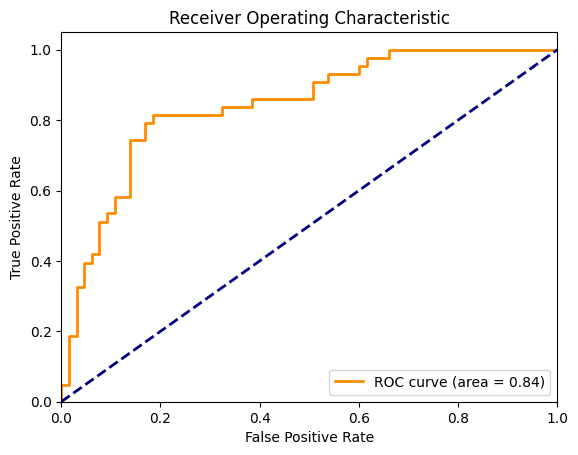

 
Accuracy: 0.7870
Precision: 0.7000
Recall: 0.8140
F1 Score: 0.7527
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.86      0.77      0.81        65
     Class 1       0.70      0.81      0.75        43

    accuracy                           0.79       108
   macro avg       0.78      0.79      0.78       108
weighted avg       0.80      0.79      0.79       108



In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, precision_score, recall_score, f1_score
import torch

# Function to calculate predictions and true labels
def get_predictions_and_labels(model, val_loader, device):
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds.extend(outputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return np.array(preds), np.array(true_labels)

# Function to plot ROC Curve
def plot_roc_curve(true_labels, preds):
    fpr, tpr, _ = roc_curve(true_labels, preds)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Function to calculate and print classification metrics
def print_classification_metrics(true_labels, preds):
    preds_binary = (preds >= 0.5).astype(int) # Threshold for binary classification
    accuracy = accuracy_score(true_labels, preds_binary)
    precision = precision_score(true_labels, preds_binary)
    recall = recall_score(true_labels, preds_binary)
    f1 = f1_score(true_labels, preds_binary)
    report = classification_report(true_labels, preds_binary, target_names=['Class 0', 'Class 1'])

    print(" ")
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('Classification Report:')
    print(report)

# Assuming you have your model, val_loader, and device already defined
# Example usage
preds, true_labels = get_predictions_and_labels(model, val_loader, device)
plot_roc_curve(true_labels, preds)
print_classification_metrics(true_labels, preds)


## Make model prediction

Saving images (2).jpeg to images (2) (1).jpeg


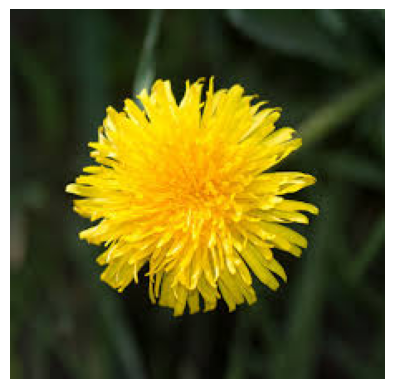

Prediksi untuk images (2) (1).jpeg: 0.0356
images (2) (1).jpeg ini adalah bunga dandelion


In [10]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor()
])

# Upload images
uploaded = files.upload()

# Predict and display images
for fn in uploaded.keys():
    # Load and preprocess image
    path = fn
    img = Image.open(path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        prob = torch.sigmoid(output).item()

    # Display image
    plt.imshow(np.array(img))
    plt.axis('off')
    plt.show()

    # Print prediction
    print(f"Prediksi untuk {fn}: {prob:.4f}")
    if prob < 0.5:
        print(f"{fn} ini adalah bunga dandelion")
    else:
        print(f"{fn} ini adalah rumput")
